# Prediction Weights

This notebook investigates the weights of features used in the model.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo

---

## Imports and Configuration

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

---

## Load Coefficients and Dataframe

In [90]:
coef = np.load('coef_elastic.npy')
coef[1, :] = coef[0, :] - coef[1, :]
coef[2, :] = coef[2, :] - coef[0, :]
print(coef[0:5])
print(coef.shape)

[[ 0.00397073  0.          0.         ... -0.00081903 -0.00377904
  -0.00337962]
 [ 0.0003545   0.          0.         ...  0.00033362  0.00059122
   0.0004243 ]
 [ 0.00077962  0.          0.         ...  0.00052056  0.0016779
   0.00061912]]
(3, 601)


In [91]:
features_df = pd.read_csv("features_binned.csv")
features_df = features_df.drop(columns=["Unnamed: 0"])
cols = features_df.columns
cols

Index(['+ve strand', 'pos_-27_A', 'pos_-27_C', 'pos_-27_G', 'pos_-27_T',
       'pos_-26_A', 'pos_-26_C', 'pos_-26_G', 'pos_-26_T', 'pos_-25_A',
       ...
       'AG_comp_0.9', 'AG_comp_1.0', 'length_18', 'length_19', 'length_20',
       'length_21', 'length_22', 'length_23', 'length_24', 'length_25'],
      dtype='object', length=601)

In [92]:
cols = np.array(cols)
cols = cols.reshape(cols.shape[0])

In [93]:
# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'x-large',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)

In [94]:
def set_graph(first, ax):
    ax.spines['left'].set_visible(first)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not first:
        ax.set_yticks([])

In [95]:
dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
print(coef[1:, dist_indices])
print(coef[1, dist_indices].reshape(2,2))
print(coef[2, dist_indices].reshape(2,2))

[[2.58995699e-04 2.94533550e-04 6.38332759e-05 1.21463806e-04]
 [5.49349902e-04 6.60959078e-04 1.24449376e-04 2.68268163e-04]]
[[2.58995699e-04 2.94533550e-04]
 [6.38332759e-05 1.21463806e-04]]
[[0.00054935 0.00066096]
 [0.00012445 0.00026827]]


In [96]:
# pandas plotting requires unusual error bar fmt
mins = coef[1, dist_indices]
maxs = coef[2, dist_indices]
cube = np.array([
                [[mins[0], mins[1]], [maxs[0], maxs[1]]], 
                [[mins[2], mins[3]], [maxs[2], maxs[3]]]
                ]
               )

In [97]:
def plot_TSS(ax, first):
    dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
    dist_coef = np.array(coef[0, dist_indices]).reshape(2,2)
    df = pd.DataFrame(dist_coef,
                     index=['Primary', 'Secondary'],
                     columns=pd.Index(['Downstream', 'Upstream'])) 

    df.plot(ax=ax, kind='bar',figsize=(10,4), color = ['w','slategrey'], 
            yerr = cube,
            capsize=4, ecolor='k',
            edgecolor='k')
    set_graph(first, ax)
    ax.set_ylim((-0.1, 0.1))
    ax.legend(fontsize=14)
    ax.title.set_text('Distance to TSS')

In [98]:
def plot_strand(ax, first):
    dist_indices = ['+ve' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    ax.bar('sense strand', dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = 'w',  edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    ax.set_xlim((-5, 5))
    set_graph(first, ax)
    ax.title.set_text('Strand Targeted')

In [99]:
def get_run(string):
    return int(re.findall('[0-9]+', string)[0])

In [102]:
def plot_length(ax, first):
    dist_indices = ['length' in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist, dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = 'w',  edgecolor='k')
    ax.axhline(linewidth = 1, color = 'k')
    ax.set_ylim((-0.1, 0.1))
    ax.set_xticks(dist)
    set_graph(first, ax)
    ax.title.set_text('Length of sgRNA')

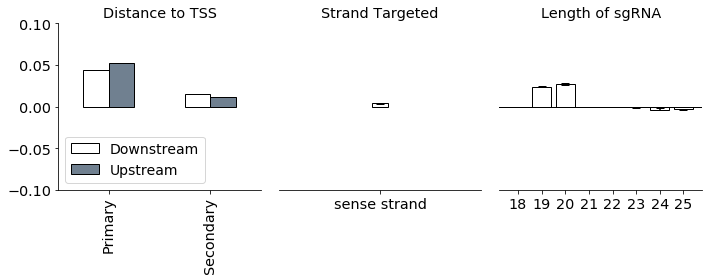

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
plot_TSS(axs[0], True)
plot_strand(axs[1], False)
plot_length(axs[2], False)
fig.tight_layout()
plt.savefig("upper")

In [104]:
# Regular expression which returns a boolean if the column name is for a nucleotide position
def find_nucl_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

In [105]:
# Regular expression which returns a boolean if the column name is for a dimer position
def find_dimer_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

In [106]:
nucl_pos_bool = [find_nucl_pos(name) for name in cols]
dimer_pos_bool = [find_dimer_pos(name) for name in cols]

In [107]:
def get_pos(string):
    return -1 * int(re.findall('[0-9]+', string)[0])

In [108]:
# Extract out position elements
nucl_pos_names = cols[nucl_pos_bool]
nucl_pos = [get_pos(name) for name in nucl_pos_names]

dimer_pos_names = cols[dimer_pos_bool]
dimer_pos = [get_pos(name) for name in dimer_pos_names]

In [109]:
nucl_coef = coef[:, nucl_pos_bool]
dimer_coef = coef[:, dimer_pos_bool]

In [110]:
def specific_nucl_pos(nucleotide):
    pos_bool = [nucleotide in name for name in nucl_pos_names]
    names = nucl_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    coef = nucl_coef[:, pos_bool]
    return (names, pos, coef)

In [111]:
A = specific_nucl_pos('A')
C = specific_nucl_pos('C')
G = specific_nucl_pos('G')
T = specific_nucl_pos('T')
nucl_pos_plot = [A, C, G, T]

In [112]:
from matplotlib.pyplot import figure

In [113]:
def pos_plot(plot_info, colors, title, legend, ax):
    width = 1/len(plot_info)
    for index, nucl in enumerate(plot_info):
        ax.bar(np.array(nucl[1]) + (index - 1)*width, nucl[2][0] + 0.001, width, 
               yerr = [nucl[2][1], nucl[2][2]], 
               ecolor = colors[index],
               color = colors[index])
    ax.legend(legend, loc='upper left', ncol=4)
    ax.set_xticks((-1 * np.arange(len(nucl[1])) - 3))
    ax.set_ylim((-0.05, 0.05))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.title.set_text(title)

In [114]:
def specific_dimer_pos(dimer):
    pos_bool = [dimer in name for name in dimer_pos_names]
    names = dimer_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    curr_coef = dimer_coef[:, pos_bool]
    return (names, pos, curr_coef)

In [115]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dimers = dimer_encodings.keys()
dimer_plot = []
for dimer in dimers:
    dimer_plot.append(specific_dimer_pos(dimer))

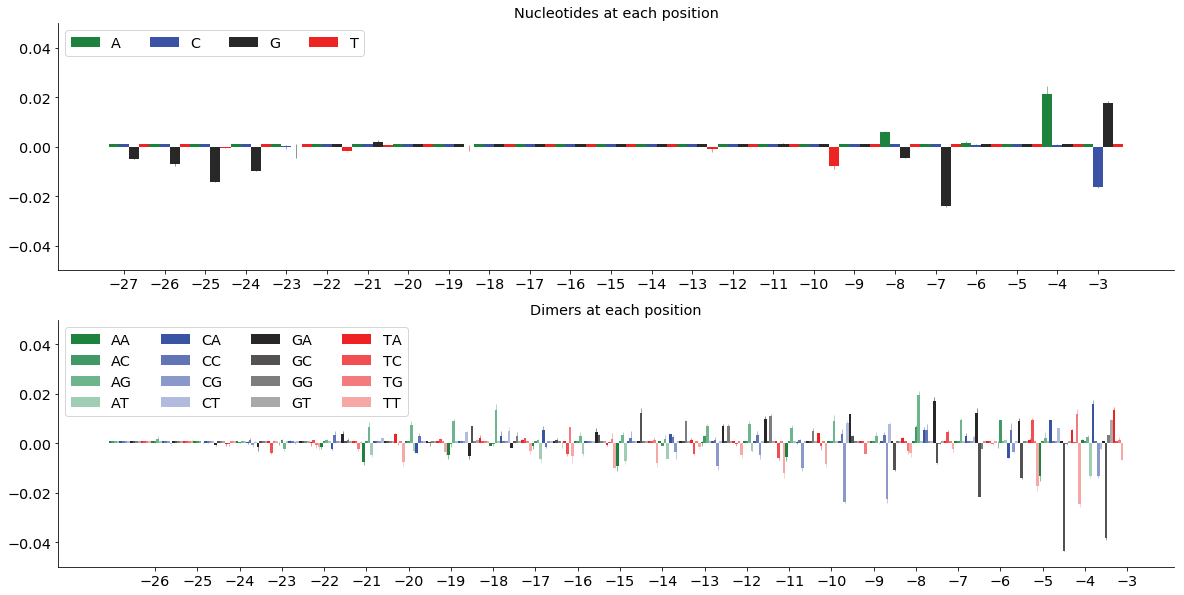

In [116]:
plt.rcParams.update({'lines.linewidth': 0.5}) # make error bars thin

f, axs = plt.subplots(2, 1,figsize=(20,10))
colors =  ['#1d823d', '#3c52a5', '#282828', '#ed2324']
pos_plot(nucl_pos_plot, colors, "Nucleotides at each position", ('A', 'C', 'G', 'T'), axs[0])
colors = ['#1d823d', '#419965', '#6eb48d', '#a0ceb4',
         '#3a54a4', '#6175b5', '#8a98ca','#b0bbdd',
         '#282626', '#535152', '#7d7d7d', '#a9a9aa',
         '#ee2225', '#f04e50', '#f47b7d', '#f5a8a6']
pos_plot(dimer_plot, colors,"Dimers at each position", dimers, axs[1])

plt.rcParams.update({'lines.linewidth': 1.5})
plt.savefig("per_position")

In [117]:
def longest_run(nucl, ax, color, first):
    dist_indices = ['longest_' + nucl in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [get_run(name) for name in dist_name]
    ax.bar(dist, dist_coef, 
           yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = color, edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    ax.axhline(linewidth = 1, color = 'k')
    set_graph(first, ax)
    ax.title.set_text('Longest consecutive run of ' + nucl)

In [118]:
def find_comp(string, nucl):
    prog = re.compile('^' + nucl + '_comp')
    result = prog.match(string)
    return bool(result)

In [119]:
def composition(nucl, ax, color, first):
    dist_indices = [find_comp(colname, nucl) for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[0, dist_indices]
    dist = [name[-3:] for name in dist_name]
    ax.bar(dist, dist_coef, yerr = coef[1:, dist_indices], 
           capsize=4, ecolor='k',
           color = color, edgecolor='k')
    ax.set_ylim((-0.1, 0.1))
    ax.axhline(linewidth = 1, color = 'k')
    set_graph(first, ax)
    ax.title.set_text('Composition of ' + nucl)

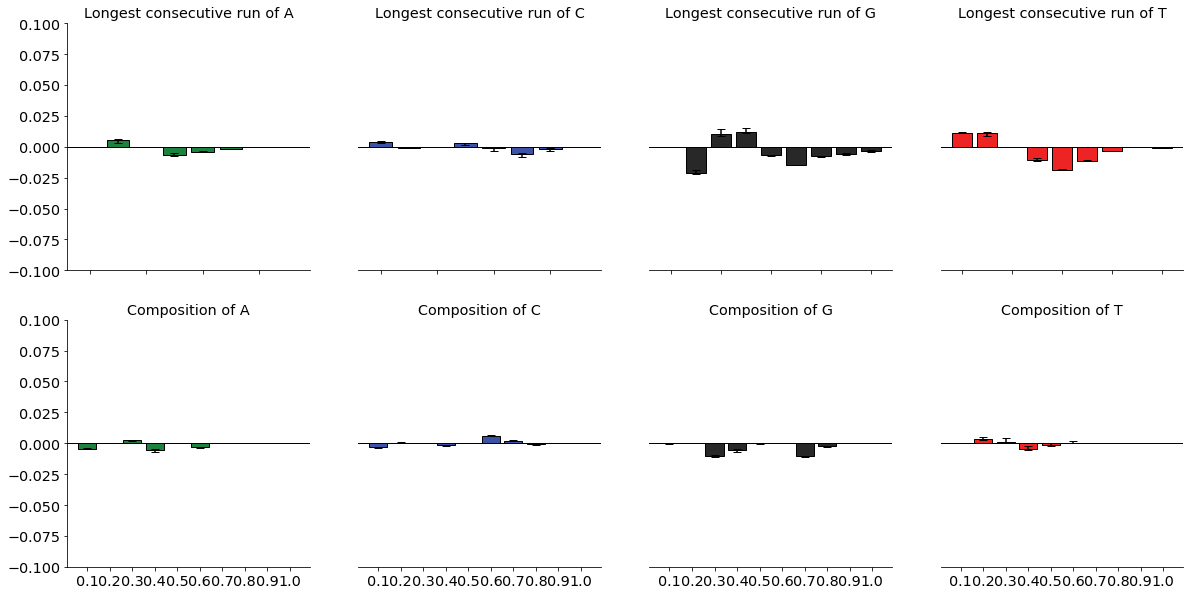

In [120]:
f, axs = plt.subplots(2,4,figsize=(20,10))

# colors = ['seagreen', 'lightcoral', 'slategrey', 'cornflowerblue']
colors = ['#1d823d', '#3c52a5', '#282828', '#ed2324']
for nucl, ax_run, ax_comp, color in [('A', axs[0, 0], axs[1, 0], colors[0]), 
                ('C', axs[0, 1], axs[1, 1], colors[1]),
                ('G', axs[0, 2], axs[1, 2], colors[2]),
                ('T', axs[0, 3], axs[1, 3], colors[3])]:
    if(ax_run == axs[0, 0]):
        longest_run(nucl, ax_run, color, True)
        composition(nucl, ax_comp, color, True)
    else:
        longest_run(nucl, ax_run, color, False)
        composition(nucl, ax_comp, color, False)

# hide outer axes 
for ax in axs.flat:
    ax.label_outer()
plt.savefig("run_comp")

# Find score contribution of aggregate features

In [121]:
contr_all = np.sum(np.absolute(np.array(features_df.iloc[:, :]) * coef[0, :]), axis=1)
contribution_full = contr_all

In [122]:
def find_contribution(dist_indices):
    contr_all = np.absolute(np.sum(np.array(features_df.iloc[:, dist_indices]) * coef[0, dist_indices], axis=1))/contribution_full
    contribution = np.percentile(contr_all, 95) - np.percentile(contr_all, 5)
    return contribution

In [123]:
# Nucleotide composition
dist_indices = [find_comp(colname, nucl) for index, colname in enumerate(cols)]
comp_contr = find_contribution(dist_indices)
comp_contr

0.026105912057677094

In [124]:
# Distance from TSS
dist_indices = ['dist' in colname for index, colname in enumerate(cols)]
TSS_contr = find_contribution(dist_indices)
TSS_contr

0.21857264634040174

In [125]:
# Homopolymer / Longest Run
dist_indices = ['longest_' + nucl in colname for index, colname in enumerate(cols)]
run_contr = find_contribution(dist_indices)
run_contr 

0.08057067875690338

In [126]:
# Strand sense
dist_indices = ['+ve' in colname for index, colname in enumerate(cols)]
strand_contr = find_contribution(dist_indices)
strand_contr

0.027783983649013518

In [127]:
# Length of sgRNA
dist_indices = ['length' in colname for index, colname in enumerate(cols)]
len_contr = find_contribution(dist_indices)
len_contr

0.16221988981665295

In [128]:
nucl_pos_bool = [find_nucl_pos(name) for name in cols]
nucl_contr = find_contribution(nucl_pos_bool)
nucl_contr

0.22447097408703068

In [129]:
dimer_pos_bool = [find_dimer_pos(name) for name in cols]
dimer_contr = find_contribution(dimer_pos_bool)
dimer_contr

0.3042215247700416

[0 3 2 4 1 5 6]


Text(0.5,1,'Score contribution \n(95th %ile - 5th %ile)')

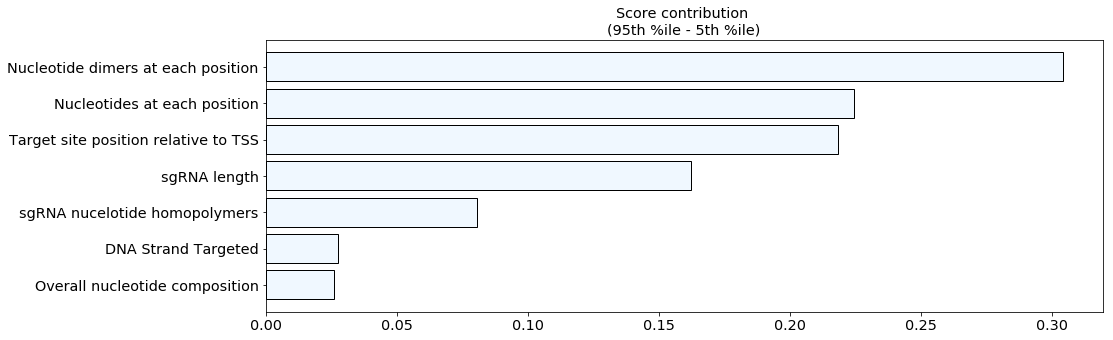

In [130]:
contr = [comp_contr, TSS_contr, run_contr, strand_contr, len_contr, nucl_contr, dimer_contr]
sorted_indices = np.argsort(contr)
contr = np.sort(contr)
print(sorted_indices)
labels = np.array(["Overall nucleotide composition",
          "Target site position relative to TSS", 
          "sgRNA nucelotide homopolymers",
          "DNA Strand Targeted",
          "sgRNA length",
          "Nucleotides at each position",
          "Nucleotide dimers at each position"])[sorted_indices]
plt.barh(labels, contr, color = 'aliceblue',  edgecolor='k')
plt.title('Score contribution \n(95th %ile - 5th %ile)')